# Download dataset

## method1. upload dataset manually (slow)

## method 2. faster way using kaggle command ( please check https://www.kaggle.com/general/74235)

## You can put the dataset in Google Drive by running the following commands

# Init and Utility

In [1]:
import warnings
import os
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython import display
from skimage import util
from skimage.transform import ProjectiveTransform, warp

import numpy as np
import random
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import torchvision.models as models
import cv2
import shutil
import warnings

/home/111065524/anaconda3/envs/DL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./computer-vision-hw4-2023/ccpd6000/') # the root directory of the datase, change to local dir

In [4]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

def draw_plate(img, kpts):
    '''Perspective tranform and draw the plate indicated by kpts to a 96x30 rectangle.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
    Return:
        img: (PIL.Image) modified image
    Reference: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    '''
    src = np.float32([[96, 30], [0, 30], [0, 0], [96, 0]])
    dst = kpts.view(4, 2).numpy()
    dst = dst * np.float32(img.size)

    transform = ProjectiveTransform()
    transform.estimate(src, dst)
    with warnings.catch_warnings(): # surpress skimage warning
        warnings.simplefilter("ignore")
        warped = warp(np.array(img), transform, output_shape=(30, 96))
        warped = util.img_as_ubyte(warped)
    plate = Image.fromarray(warped)
    img.paste(plate)
    return img

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


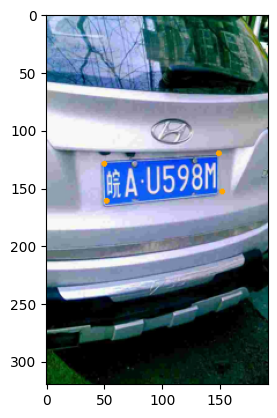

In [6]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of
                bottom-right, bottom-left, top-left, top-right corners.
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img_path = self.img_paths[idx]

        # load image
        img = Image.open(img_path)
        W, H = img.size
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)

        # parse annotation
        kpt = self.anns[idx]
        kpt = list(kpt.values())[1:9]
        kpt = torch.tensor(kpt) # [8,]
        kpt = kpt.view(4, 2) # [4, 2]
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1) # [8,]

        return img, kpt


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()


# Network

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary

        # # TODO : add more layers to achieve better performance
        # self.features = nn.Sequential(
        #     ConvBlock(3,32),
        #     ConvBlock(32,64),
        #     nn.Flatten()
        # )
        resnet18 = models.resnet18(pretrained=True)
        self.features = nn.Sequential(
            *list(resnet18.children())[:-1],
            nn.Flatten()
        )

        # # TODO : add ouput layer to predict position
        # # Note : the orginal kpts of data have been normalized (0-1)
        self.regression = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Sigmoid()
        )



    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        features = self.features(img_b)
        # print(features.size())
        kpt_b = self.regression(features)
        return kpt_b


# Do some checking
loader = DataLoader(data, batch_size=32) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([32, 3, 320, 192])
torch.Size([32, 8])


/home/111065524/anaconda3/envs/DL/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/111065524/anaconda3/envs/DL/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/111065524/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 49.3MB/s]


tensor(0.1200, device='cuda:0', grad_fn=<MeanBackward0>)


In [9]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [10]:
import gc
torch.cuda.empty_cache()
gc.collect()

3214

# Training

/home/111065524/anaconda3/envs/DL/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/111065524/anaconda3/envs/DL/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Adjusting learning rate of group 0 to 9.0000e-04.


100%|██████████| 150/150 [01:08<00:00,  2.20it/s]


Adjusting learning rate of group 0 to 7.6500e-04.
lr: 0.000765
Epoch 000:
train loss: 0.040998233097294966
valid loss: 0.017929045704046364


100%|██████████| 150/150 [00:28<00:00,  5.22it/s]


Adjusting learning rate of group 0 to 6.5025e-04.
lr: 0.0006502499999999999
Epoch 001:
train loss: 0.02315137382596731
valid loss: 0.02193652725729503


100%|██████████| 150/150 [00:28<00:00,  5.33it/s]


Adjusting learning rate of group 0 to 5.5271e-04.
lr: 0.0005527124999999999
Epoch 002:
train loss: 0.02165711206694444
valid loss: 0.020992981220938657


100%|██████████| 150/150 [00:28<00:00,  5.31it/s]


Adjusting learning rate of group 0 to 4.6981e-04.
lr: 0.0004698056249999999
Epoch 003:
train loss: 0.017953456547111273
valid loss: 0.01962912572841895


100%|██████████| 150/150 [00:28<00:00,  5.34it/s]


Adjusting learning rate of group 0 to 3.9933e-04.
lr: 0.0003993347812499999
Epoch 004:
train loss: 0.016003299200286467
valid loss: 0.014426892329203455


100%|██████████| 150/150 [00:28<00:00,  5.30it/s]


Adjusting learning rate of group 0 to 3.3943e-04.
lr: 0.0003394345640624999
Epoch 005:
train loss: 0.015463722354422013
valid loss: 0.012779753704212214


100%|██████████| 150/150 [00:28<00:00,  5.34it/s]


Adjusting learning rate of group 0 to 2.8852e-04.
lr: 0.0002885193794531249
Epoch 006:
train loss: 0.013437694665044546
valid loss: 0.012773087762884404


100%|██████████| 150/150 [00:28<00:00,  5.25it/s]


Adjusting learning rate of group 0 to 2.4524e-04.
lr: 0.0002452414725351562
Epoch 007:
train loss: 0.013221879564225674
valid loss: 0.018236748629102583


100%|██████████| 150/150 [00:27<00:00,  5.38it/s]


Adjusting learning rate of group 0 to 2.0846e-04.
lr: 0.00020845525165488275
Epoch 008:
train loss: 0.011454122941941022
valid loss: 0.009582001250237226


100%|██████████| 150/150 [00:27<00:00,  5.41it/s]


Adjusting learning rate of group 0 to 1.7719e-04.
lr: 0.00017718696390665032
Epoch 009:
train loss: 0.010956564260025819
valid loss: 0.00945912638532096


100%|██████████| 150/150 [00:27<00:00,  5.39it/s]


Adjusting learning rate of group 0 to 1.5061e-04.
lr: 0.00015060891932065277
Epoch 010:
train loss: 0.00945638122037053
valid loss: 0.009015603125781604


100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Adjusting learning rate of group 0 to 1.2802e-04.
lr: 0.00012801758142255484
Epoch 011:
train loss: 0.009756720339258512
valid loss: 0.00840128111456962


100%|██████████| 150/150 [00:28<00:00,  5.32it/s]


Adjusting learning rate of group 0 to 1.0881e-04.
lr: 0.00010881494420917162
Epoch 012:
train loss: 0.00878296312255164
valid loss: 0.00789623917080462


100%|██████████| 150/150 [00:28<00:00,  5.28it/s]


Adjusting learning rate of group 0 to 9.2493e-05.
lr: 9.249270257779588e-05
Epoch 013:
train loss: 0.007956423747042815
valid loss: 0.008295340071383276


100%|██████████| 150/150 [00:27<00:00,  5.37it/s]


Adjusting learning rate of group 0 to 7.8619e-05.
lr: 7.861879719112649e-05
Epoch 014:
train loss: 0.007365407378723224
valid loss: 0.007862753394108853


100%|██████████| 150/150 [00:28<00:00,  5.32it/s]


Adjusting learning rate of group 0 to 6.6826e-05.
lr: 6.682597761245751e-05
Epoch 015:
train loss: 0.007019140875587861
valid loss: 0.007546748193961225


100%|██████████| 150/150 [00:27<00:00,  5.38it/s]


Adjusting learning rate of group 0 to 5.6802e-05.
lr: 5.680208097058888e-05
Epoch 016:
train loss: 0.006720146331936121
valid loss: 0.007476791580158629


100%|██████████| 150/150 [00:28<00:00,  5.34it/s]


Adjusting learning rate of group 0 to 4.8282e-05.
lr: 4.8281768825000544e-05
Epoch 017:
train loss: 0.0067216049848745265
valid loss: 0.007921050547769195


100%|██████████| 150/150 [00:28<00:00,  5.31it/s]


Adjusting learning rate of group 0 to 4.1040e-05.
lr: 4.103950350125046e-05
Epoch 018:
train loss: 0.006398130708063643
valid loss: 0.008004142106265613


100%|██████████| 150/150 [00:28<00:00,  5.26it/s]


Adjusting learning rate of group 0 to 3.4884e-05.
lr: 3.4883577976062895e-05
Epoch 019:
train loss: 0.006048573013395071
valid loss: 0.007435166326008345


100%|██████████| 150/150 [00:28<00:00,  5.26it/s]


Adjusting learning rate of group 0 to 2.9651e-05.
lr: 2.965104127965346e-05
Epoch 020:
train loss: 0.005895364234844843
valid loss: 0.00748752172742235


100%|██████████| 150/150 [00:28<00:00,  5.35it/s]


Adjusting learning rate of group 0 to 2.5203e-05.
lr: 2.520338508770544e-05
Epoch 021:
train loss: 0.005529801674808065
valid loss: 0.007446636433566087


100%|██████████| 150/150 [00:28<00:00,  5.21it/s]


Adjusting learning rate of group 0 to 2.1423e-05.
lr: 2.1422877324549623e-05
Epoch 022:
train loss: 0.005505086829264959
valid loss: 0.0074704959988594055


100%|██████████| 150/150 [00:28<00:00,  5.26it/s]


Adjusting learning rate of group 0 to 1.8209e-05.
lr: 1.820944572586718e-05
Epoch 023:
train loss: 0.005425378057795267
valid loss: 0.00755580171550575


100%|██████████| 150/150 [00:28<00:00,  5.23it/s]


Adjusting learning rate of group 0 to 1.5478e-05.
lr: 1.5478028866987102e-05
Epoch 024:
train loss: 0.005189321778404216
valid loss: 0.007387392088084629


100%|██████████| 150/150 [00:28<00:00,  5.35it/s]


Adjusting learning rate of group 0 to 1.3156e-05.
lr: 1.3156324536939036e-05
Epoch 025:
train loss: 0.005179235382626454
valid loss: 0.007494657680294232


100%|██████████| 150/150 [00:28<00:00,  5.30it/s]


Adjusting learning rate of group 0 to 1.1183e-05.
lr: 1.118287585639818e-05
Epoch 026:
train loss: 0.005089651298088332
valid loss: 0.007439313223585486


100%|██████████| 150/150 [00:27<00:00,  5.36it/s]


Adjusting learning rate of group 0 to 9.5054e-06.
lr: 9.505444477938453e-06
Epoch 027:
train loss: 0.00497959425052007
valid loss: 0.007428776913959729


100%|██████████| 150/150 [00:28<00:00,  5.30it/s]


Adjusting learning rate of group 0 to 8.0796e-06.
lr: 8.079627806247684e-06
Epoch 028:
train loss: 0.004858404736345013
valid loss: 0.00744745505385493


100%|██████████| 150/150 [00:27<00:00,  5.38it/s]


Adjusting learning rate of group 0 to 6.8677e-06.
lr: 6.867683635310531e-06
Epoch 029:
train loss: 0.004926974650782843
valid loss: 0.007432561183936502


100%|██████████| 150/150 [00:28<00:00,  5.29it/s]


Adjusting learning rate of group 0 to 5.8375e-06.
lr: 5.837531090013951e-06
Epoch 030:
train loss: 0.004902412548350791
valid loss: 0.007489158931237303


100%|██████████| 150/150 [00:28<00:00,  5.21it/s]


Adjusting learning rate of group 0 to 4.9619e-06.
lr: 4.961901426511858e-06
Epoch 031:
train loss: 0.004929344727036854
valid loss: 0.007422774184593244


100%|██████████| 150/150 [00:28<00:00,  5.22it/s]


Adjusting learning rate of group 0 to 4.2176e-06.
lr: 4.217616212535079e-06
Epoch 032:
train loss: 0.004859938023922344
valid loss: 0.007467694948182294


100%|██████████| 150/150 [00:27<00:00,  5.38it/s]


Adjusting learning rate of group 0 to 3.5850e-06.
lr: 3.584973780654817e-06
Epoch 033:
train loss: 0.004771850124622385
valid loss: 0.007536966709027949


100%|██████████| 150/150 [00:28<00:00,  5.28it/s]


Adjusting learning rate of group 0 to 3.0472e-06.
lr: 3.0472277135565945e-06
Epoch 034:
train loss: 0.00470300253170232
valid loss: 0.0075172120950331815


100%|██████████| 150/150 [00:28<00:00,  5.25it/s]


Adjusting learning rate of group 0 to 2.5901e-06.
lr: 2.590143556523105e-06
Epoch 035:
train loss: 0.0047069051954895256
valid loss: 0.007615697888755484


100%|██████████| 150/150 [00:28<00:00,  5.28it/s]


Adjusting learning rate of group 0 to 2.2016e-06.
lr: 2.2016220230446392e-06
Epoch 036:
train loss: 0.004782526929241916
valid loss: 0.007492932172394113


100%|██████████| 150/150 [00:28<00:00,  5.34it/s]


Adjusting learning rate of group 0 to 1.8714e-06.
lr: 1.8713787195879433e-06
Epoch 037:
train loss: 0.004659312857935826
valid loss: 0.00748572493658254


100%|██████████| 150/150 [00:28<00:00,  5.35it/s]


Adjusting learning rate of group 0 to 1.5907e-06.
lr: 1.5906719116497517e-06
Epoch 038:
train loss: 0.004669563417943816
valid loss: 0.007420201504014824


100%|██████████| 150/150 [00:28<00:00,  5.22it/s]


Adjusting learning rate of group 0 to 1.3521e-06.
lr: 1.352071124902289e-06
Epoch 039:
train loss: 0.004710232995760937
valid loss: 0.007494742847292831


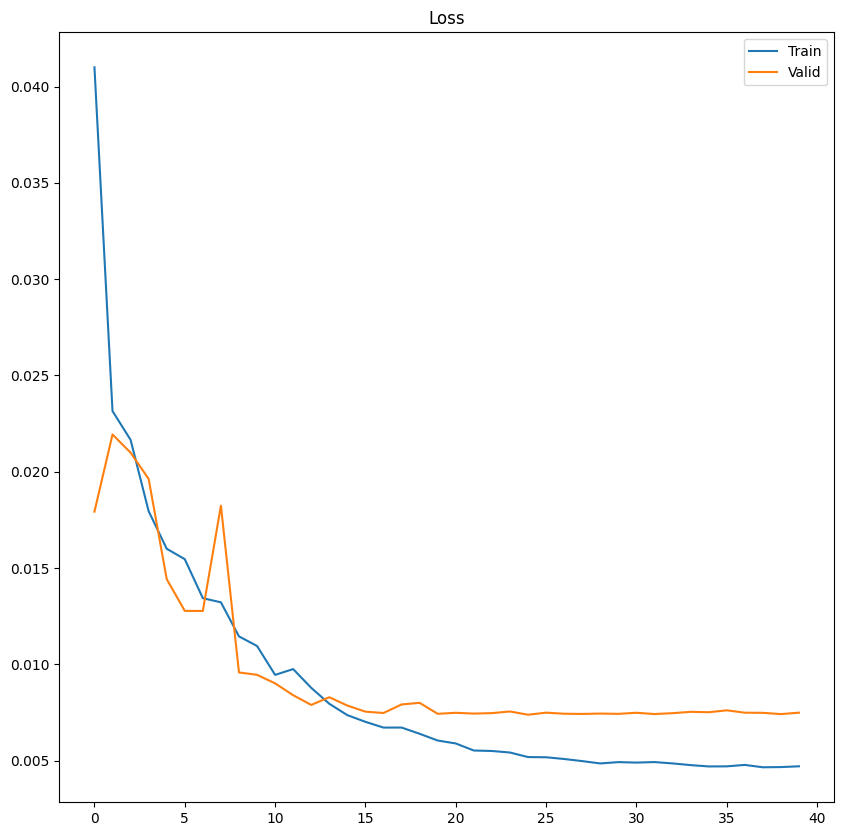

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


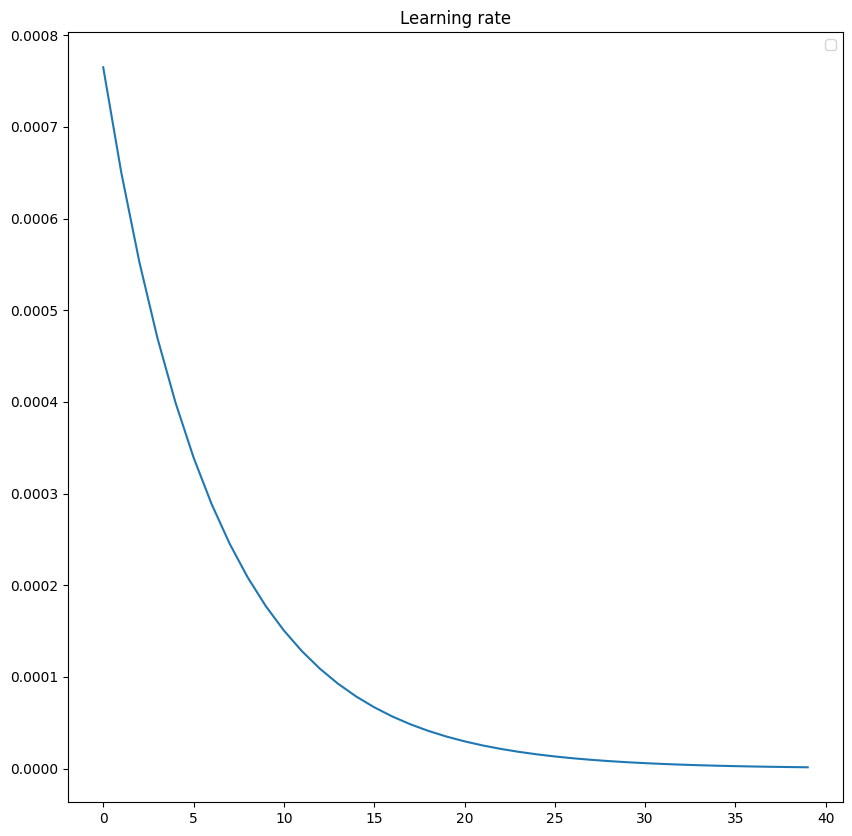

In [11]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))

        self.train_loader = DataLoader(self.train_set, 16, shuffle=True, num_workers=0)
        self.valid_loader = DataLoader(self.valid_set, 16, shuffle=False, num_workers=0)

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        # self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=9e-4)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.85, last_epoch=-1, verbose=True)
        # self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', verbose=True)
        self.max_epoch = 40 #TODO define your training epochs

    def run(self):
        training_result_dir = self.log_dir / 'training_result'
        training_result_dir.mkdir(parents=True)
        metrics = {'train_loss': [], 'valid_loss': []}
        lrs = []
        for self.epoch in range(self.max_epoch): # epochs
            train_loss = self.train() # train 1 epoch
            valid_loss = self.valid() # valid 1 epoch
            print('lr:',get_lr(self.optimizer))
            lrs.append(get_lr(self.optimizer))
            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            # Save the parameters(weights) of the model to disk
            if torch.tensor(metrics['valid_loss']).argmin() == self.epoch:
                torch.save(self.model.state_dict(), str(training_result_dir / 'model.pth'))
        
        # Plot the loss curve against epoch
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
        ax.set_title('Loss')
        ax.plot(range(self.epoch + 1), metrics['train_loss'], label='Train')
        ax.plot(range(self.epoch + 1), metrics['valid_loss'], label='Valid')
        ax.legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'metrics.jpg'))
        plt.close()

        fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
        ax.set_title('Learning rate')
        ax.plot(range(self.epoch + 1), lrs)
        ax.legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'lr.jpg'))
        plt.close()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in tqdm(iter(self.train_loader)):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            self.optimizer.zero_grad()
            pred_b = self.model(img_b)
            # TODO
            # step 1 caculate the loss
            loss = self.criterion(pred_b, kpt_b)
            # step 2 back propagation
            loss.backward()
            # step 3 update parameters using optimizer
            self.optimizer.step()
            loss_steps.append(loss.detach().item())
        
        avg_loss = sum(loss_steps) / len(loss_steps)
        self.scheduler.step()
        return avg_loss

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.valid_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            loss_steps.append(loss.detach().item())
            
        avg_loss = sum(loss_steps) / len(loss_steps)
        # self.scheduler.step(avg_loss)
        return avg_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


log_dir = Path('./runs/') / f'{datetime.now():%b%d_%H_%M_%S}'
log_dir.mkdir(parents=True, exist_ok=True)
Trainer(log_dir).run()

# Testing

In [12]:
# Do testing
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

#import utils
#from utils.model import CCPDRegressor
img_size=(192, 320)
class CCPDTest:
    def __init__(self, img_dir):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('./computer-vision-hw4-2023/ccpd6000/test_images')
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=0)

device = 'cuda'
model = Net().to(device)
model.load_state_dict(torch.load(str(log_dir / 'training_result/model.pth')))
model.eval()
print(str(log_dir / 'training_result/model.pth'))

log_dir_test = Path('./testing_result') / f'{datetime.now():%b%d_%H_%M_%S}'
log_dir_test.mkdir(parents=True)
print(log_dir_test)

def test(pbar):
    model.eval()
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()
        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, kpt)
            vis = draw_kpts(vis, kpt, c='red')
            vis.save(log_dir_test / f'{pbar.n:03d}_vis.jpg')
            # Original image size: 720 * 1160
            kpt[0:-1:2] *= 720
            kpt[1::2] *= 1160
            anns.append([f'{pbar.n:04d}.jpg', *kpt.numpy().tolist()])
            pbar.update()

    return pd.DataFrame(anns)

with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv(str(log_dir_test / 'test_pred.csv'), float_format='%.5f', index=False)

/home/111065524/anaconda3/envs/DL/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/111065524/anaconda3/envs/DL/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


runs/Dec18_06_34_41/training_result/model.pth
testing_result/Dec18_07_12_04


100%|██████████| 3000/3000 [01:02<00:00, 48.30it/s]


In [13]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

11209864

# Report

Overlay training losses and validation losses in the same figure against each epoch:

We can see valid loss converges at around 25th epoch:

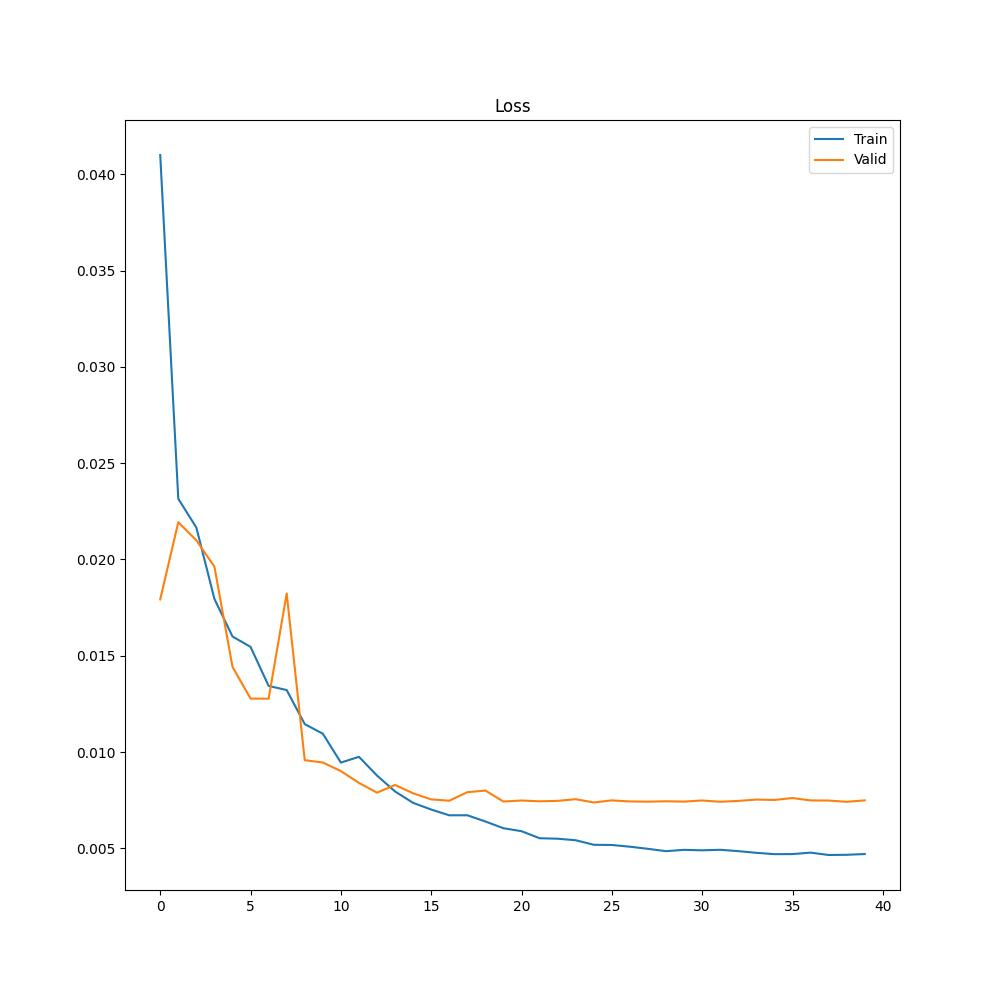

Visualization results of your final model on: (1)test_images/0000.jpg, (2)test_images/1000.jpg:

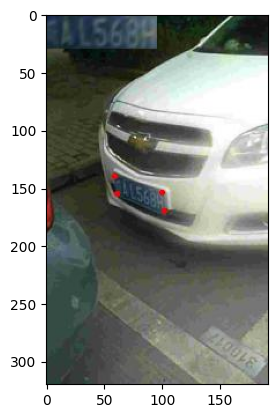

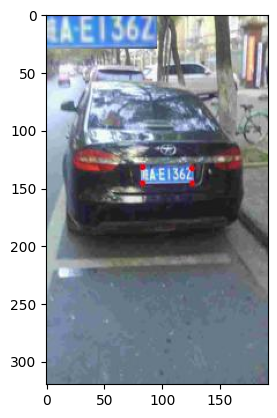

In [10]:
img1 = cv2.imread(str(log_dir_test / '000_vis.jpg'))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(str(log_dir_test / '1000_vis.jpg'))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

The number of total parameters and trainable parameters.

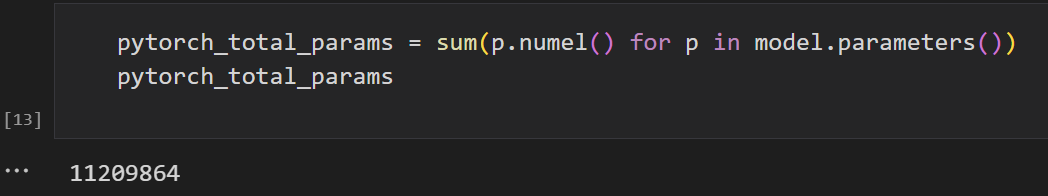

The hyperparameters(epochs, learning rate, loss function, optimizer) of your final model:

Here we use L1Loss as loss function, adam as our optimizer, learning rate decay 0.85 every epoch(start from 9e-4), and set total epoch to 40, we also show learning rate change as epoch increases.

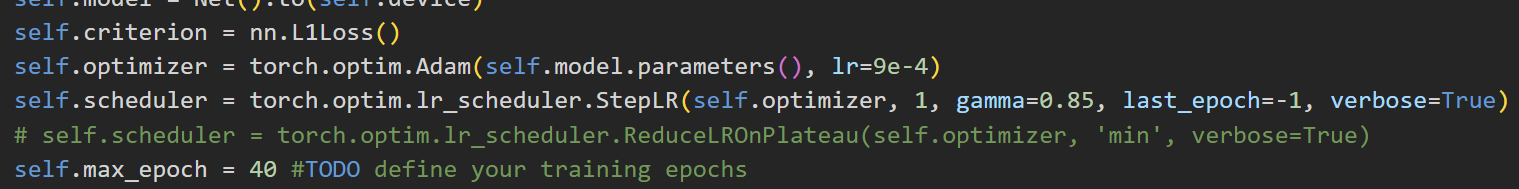
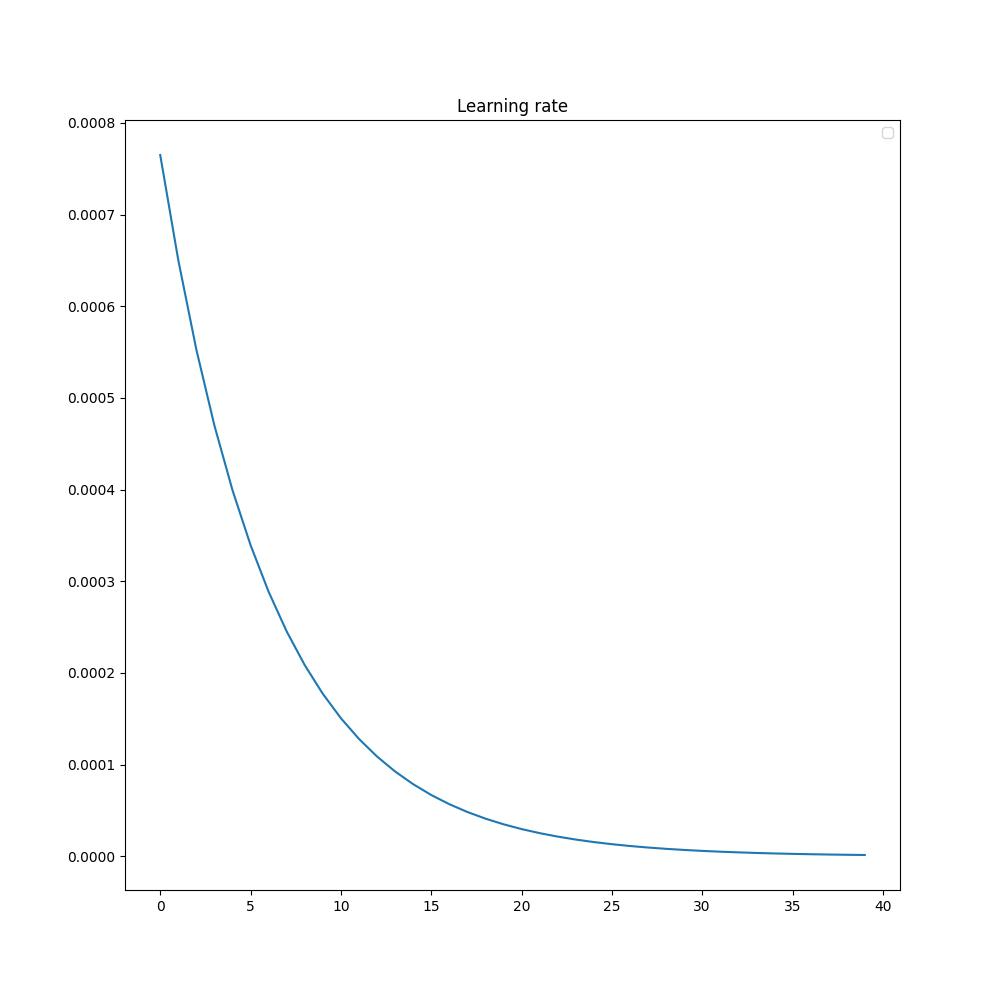

We've also tried MSEloss for our loss function, but it does not show too much improvement.


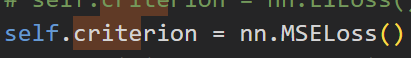

Describe and compare the methods you have tried in this project:

We compare some of the results with different model and hyperparameters, we can see that with pretrained Resent18, our results improve significantly compared to stacking Convolution block, and by tuning other training parameters, there are also some minor improvements, for example, using learning rate decay(needs to tune step and decay rate):

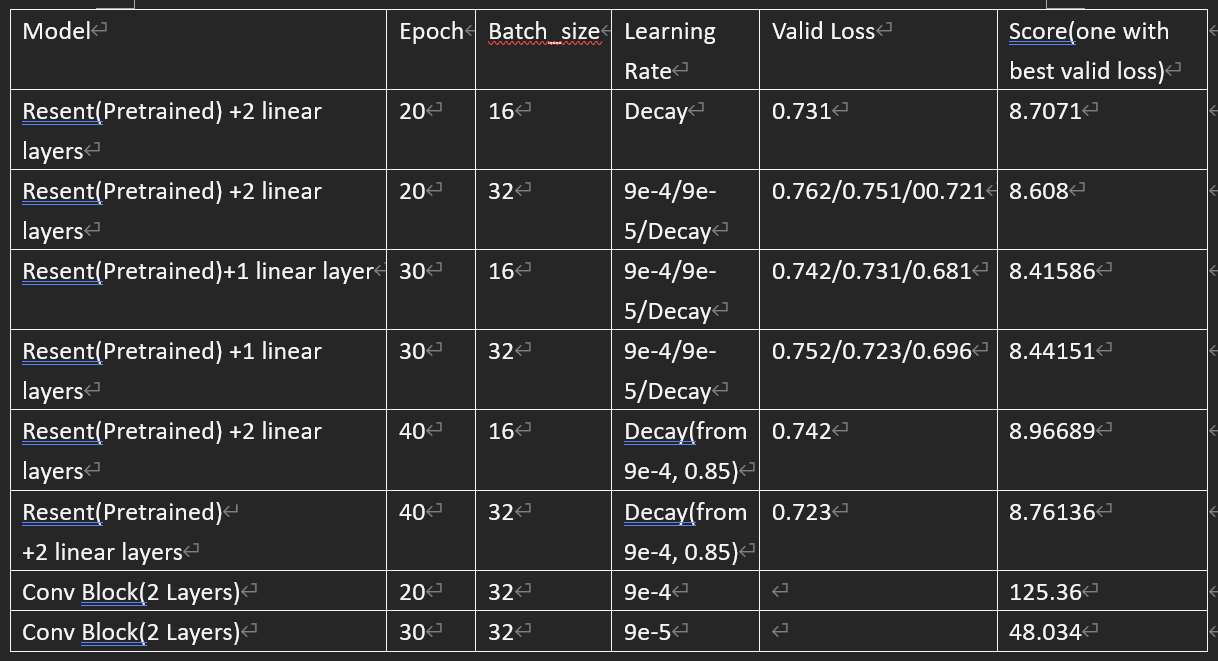